# **PFA Project**



#*Detecting Arabic Fake News with Bert*

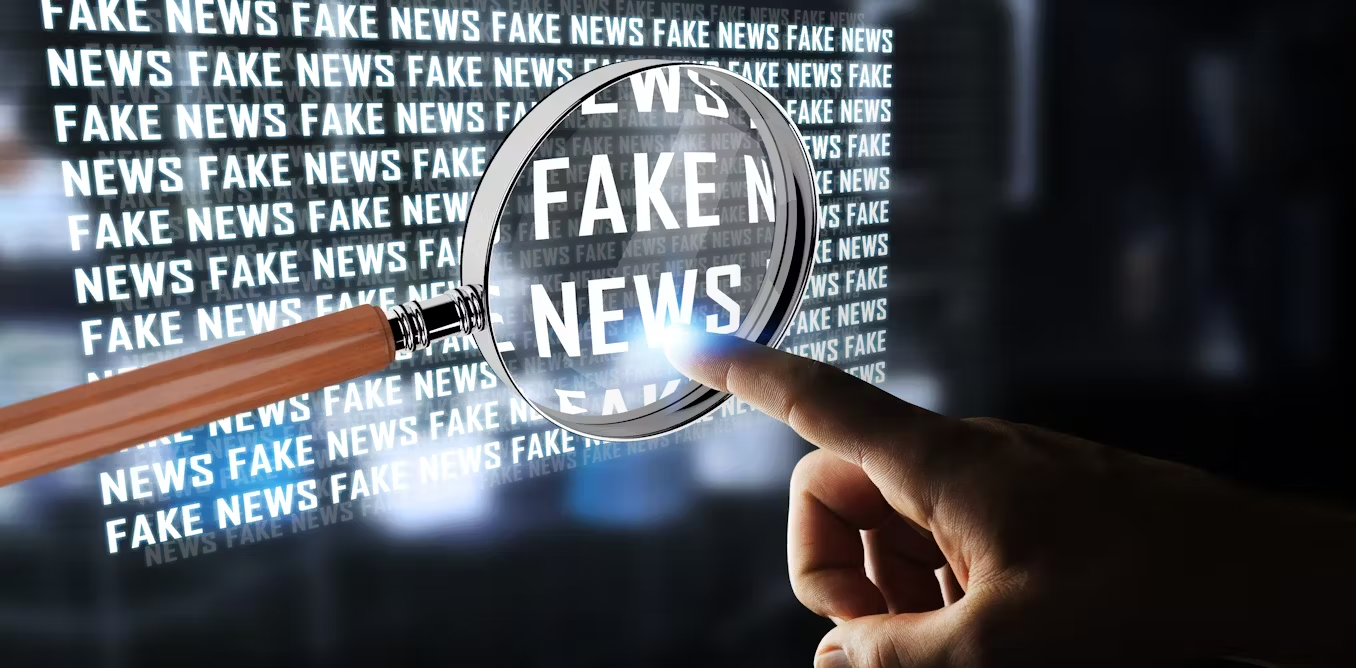

## 1. Packages Import

In [ ]:
import re
!pip install nltk
import nltk
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
import pickle
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import AdamW, get_linear_schedule_with_warmup
import numpy as np
import copy
# Install and download NLTK resources
!pip install scikit-learn==0.24.2
# Download NLTK resources
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')


In [ ]:
!python --version

## 2. Data Preparation


### 2.1 data importation

In [ ]:
!pip install openpyxl

In [ ]:
df = pd.read_csv("5000_shuffled.csv")


### 2.2 Data understanding

In [ ]:
df.head()

In [ ]:
df['text']

In [ ]:
df.info()

In [ ]:
num_rows, num_cols = df.shape
print("Number of rows:", num_rows)
print("Number of columns:", num_cols)


In [ ]:
print(df.dtypes)


In [ ]:
column_names = df.columns.tolist()
print("Column names:", column_names)


In [ ]:
print("Missing values:\n", df.isnull().sum())


In [ ]:
label_counts = df['label'].value_counts()
print("Number of credibale comments:", label_counts[1])
print("Number of not credibale comments:", label_counts[0])


In [ ]:
df.head()

In [ ]:
num_classes = df['label'].nunique()
print("Number of classes:", num_classes)

### <span style="color:white; background-color:gray"> This dataset includes :

1.   5000 samples
2.   2 classes which are Credible and not credible


In [ ]:
# Define datasets and models
models = [
    {"name": "AraBERTv02", "tokenizer": "aubmindlab/bert-base-arabertv02", "model": "aubmindlab/bert-base-arabertv02"},
    {"name": "AraBERTv02_large", "tokenizer": "aubmindlab/bert-large-arabertv02", "model": "aubmindlab/bert-large-arabertv02"},
    {"name": "AraBERTv2", "tokenizer": "aubmindlab/bert-base-arabertv2", "model": "aubmindlab/bert-base-arabertv2"},
    {"name": "AraBERTv2_large", "tokenizer": "aubmindlab/bert-large-arabertv2", "model": "aubmindlab/bert-large-arabertv2"}
]
datasets = ["5000_shuffled.csv",
            "5000_credible_shuffled.csv",
           "5000_uncredible_shuffled.csv"
            ]

### 2.3 Data Preparation

#### 2.3.1 Data cleaning

In [ ]:
print(df['text'])

In [ ]:
# Convert 'publishing_date' column to datetime format
df['publishing_date'] = pd.to_datetime(df['publishing_date'], format='ISO8601')


In [ ]:
# Remove any leading or trailing whitespace from 'title' and 'text' columns
df['title'] = df['title'].str.strip()
df['text'] = df['text'].str.strip()

In [ ]:
# Remove any leading or trailing whitespace from 'source_num' column
df['source_num'] = df['source_num'].str.strip()

In [ ]:
# Convert 'label' column to categorical type
df['label'] = df['label'].astype('category')

In [ ]:
# Print first few rows of the preprocessed dataset
print(df.head())

In [ ]:
class NewsDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        if self.labels is not None:
            item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

In [ ]:
import re

def clean_text(text):
    # Remove non-Arabic characters
    text = text.str.replace(r'[^\u0621-\u064A\s]', ' ', regex=True)  # Arabic Unicode range
    # Remove HTML tags
    text = text.str.replace(r'<.*?>', '', regex=True)
    # Remove multiple white spaces
    text = text.str.replace(r'\s+', ' ', regex=True)
    # Remove single characters except spaces
    text = text.str.replace(r'\b\w\b', '', regex=True)
    # Strip leading and trailing spaces
    text = text.str.strip()
    return text



# Function to preprocess text data
def preprocess_text(df):
    # Drop duplicate rows
    df.drop_duplicates(inplace=True)
    # Clean text
    df['text'] = clean_text(df['text'])
    # Keep only alphanumeric and space characters
    df['text'] = df['text'].apply(lambda x: ''.join(char for char in x if char.isnumeric() or char.isalpha() or char.isspace()))
    return df



In [ ]:
def normalize_arabic(text):
    text = re.sub("[إأآا]", "ا", text)
    text = re.sub("ى", "ي", text)
    text = re.sub("ؤ", "ء", text)
    text = re.sub("ئ", "ء", text)
    text = re.sub("ة", "ه", text)
    text = re.sub("گ", "ك", text)
    return text

In [ ]:
df['text'] = clean_text(df['text'])
df['text'] = df['text'].apply(normalize_arabic)
df['title'] = clean_text(df['title'])
df['title'] = df['title'].apply(normalize_arabic)
# Print first few rows of the preprocessed dataset
print(df.head())

In [ ]:
df = preprocess_text(df)

In [ ]:
def preprocess_and_tokenize(df, tokenizer_name):
    tokenizer = AutoTokenizer.from_pretrained(tokenizer_name)
    df['text'] = df['text'].apply(clean_text)  # Clean text
    df['text'] = df['text'].apply(normalize_arabic)  # Normalize Arabic text
    encodings = tokenizer(list(df['text']), truncation=True, padding=True, max_length=128)
    labels = df['label'].map({'credible': 1, 'not credible': 0}).tolist()  # Ensure labels are converted to list
    return encodings, labels

In [ ]:
def create_dataloader(encodings, labels, batch_size=16):
    dataset = NewsDataset(encodings, labels)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    return dataloader

In [ ]:
def clean_text(text):
    text = re.sub(r'[^\u0621-\u064A\s]', ' ', text)  # Arabic Unicode range
    text = re.sub(r'<.*?>', '', text)
    text = re.sub(r'\s+', ' ', text)
    text = re.sub(r'\b\w\b', '', text)
    text = text.strip()
    return text

#### 2.3.2 Word Embedding using TF-IDF Vectorizer and Train Test Split Data

In [ ]:
# Arabic stopwords
arabic_stopwords = set(stopwords.words('arabic'))

# Initialization of the TF-IDF Vectorizer
vectorizer = TfidfVectorizer()

# Ensure 'text' column is string type
df['text'] = df['text'].astype(str)

# Tokenize Arabic text using word_tokenize from NLTK
df['text'] = df['text'].apply(lambda x: word_tokenize(x))

# Join tokenized text back into sentences
df['text'] = df['text'].apply(lambda x: ' '.join(x))

# Apply the vectorizer on text
X_text = vectorizer.fit_transform(df['text']).toarray()

# Apply the vectorizer on text
X = vectorizer.fit_transform(df['text']).toarray()

# Convert categorical columns to numerical using get_dummies
X_categorical = pd.get_dummies(df[['title', 'source_num']])

# Concatenate numerical features and text features
X = pd.concat([pd.DataFrame(X_text), X_categorical], axis=1)

# Define target variable
y = df['label']
# Encode labels
df['label'] = df['label'].map({'credible': 0, 'not credible': 1})


# Split the data into train, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)
# Convert feature names to strings
X_train.columns = X_train.columns.astype(str)
X_valid.columns = X_valid.columns.astype(str)
X_test.columns = X_test.columns.astype(str)


In [ ]:
df.head()

In [ ]:
# Concatenate all text into a single string
all_text = ' '.join(df['text'])

# Tokenize the text using NLTK's word_tokenize
tokens = nltk.word_tokenize(all_text)

# Count the frequency of each token
word_freq = Counter(tokens)

# Get the most common words and their frequencies
top_words = word_freq.most_common(10)

# Separate words and frequencies
words, frequencies = zip(*top_words)

# Plot the most common words
plt.bar(words, frequencies)
plt.title('Top 10 Most Common Words')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.show()


##3. Data Training

In [ ]:
def evaluate(model, dataloader):
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
    model.to(device)
    model.eval()
    total_loss = 0
    preds, labels = [], []
    with torch.no_grad():
        for batch in dataloader:
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**batch)
            loss = outputs.loss
            total_loss += loss.item()
            preds.append(outputs.logits.argmax(dim=-1).cpu().numpy())
            labels.append(batch['labels'].cpu().numpy())
    preds = np.concatenate(preds)
    labels = np.concatenate(labels)
    avg_loss = total_loss / len(dataloader)
    return avg_loss, preds, labels

In [ ]:
def train_and_evaluate(model_name, tokenizer_name, train_dataloader, valid_dataloader, epochs=3, learning_rate=2e-5):
    tokenizer = AutoTokenizer.from_pretrained(tokenizer_name)
    model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
    model.to(device)

    optimizer = AdamW(model.parameters(), lr=learning_rate)
    total_steps = len(train_dataloader) * epochs
    scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

    best_valid_loss = float('inf')
    no_improvement_epochs = 0
    early_stopping_patience = 3
    gradient_clipping_value = 1.0

    best_model_state = copy.deepcopy(model.state_dict())

    def train_epoch():
        model.train()
        total_loss = 0
        for batch in train_dataloader:
            optimizer.zero_grad()
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**batch)
            loss = outputs.loss
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), gradient_clipping_value)
            optimizer.step()
            scheduler.step()
            total_loss += loss.item()
        return total_loss / len(train_dataloader)

    for epoch in range(epochs):
        train_loss = train_epoch()
        valid_loss, y_pred_valid, y_true_valid = evaluate(model, valid_dataloader)

        print(f'Epoch {epoch+1}/{epochs}')
        print(f'Train Loss: {train_loss}')
        print(f'Validation Loss: {valid_loss}')
        print(classification_report(y_true_valid, y_pred_valid))

        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            no_improvement_epochs = 0
            best_model_state = copy.deepcopy(model.state_dict())
        else:
            no_improvement_epochs += 1
            if no_improvement_epochs >= early_stopping_patience:
                print("Early stopping triggered")
                break

    # Load the best model state
    model.load_state_dict(best_model_state)
    return model

##4. Data Evaluation

In [ ]:
def test_model(model, test_dataloader):
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
    model.to(device)
    test_loss, y_pred_test, y_true_test = evaluate(model, test_dataloader)
    print("**************  Performance on Test Set  ********************")
    print(classification_report(y_true_test, y_pred_test))
    return classification_report(y_true_test, y_pred_test, output_dict=True)


In [41]:
results = []

for dataset in datasets:
    df = pd.read_csv(dataset, encoding='utf-8', sep=',')
    for model_config in models:
        print(f"Training on {dataset} with {model_config['name']}")

        train_df, test_df = train_test_split(df, test_size=0.15, random_state=42)
        train_df, valid_df = train_test_split(train_df, test_size=0.15, random_state=42)

        train_encodings, train_labels = preprocess_and_tokenize(train_df, model_config['tokenizer'])
        valid_encodings, valid_labels = preprocess_and_tokenize(valid_df, model_config['tokenizer'])
        test_encodings, test_labels = preprocess_and_tokenize(test_df, model_config['tokenizer'])

        train_dataloader = create_dataloader(train_encodings, train_labels)
        valid_dataloader = create_dataloader(valid_encodings, valid_labels)
        test_dataloader = create_dataloader(test_encodings, test_labels)

        # Train and evaluate the model
        model = train_and_evaluate(model_config['model'], model_config['tokenizer'], train_dataloader, valid_dataloader)

        # Test the model
        result = test_model(model, test_dataloader)

        # Save model
        model_name = f"{dataset}_{model_config['name']}.pickle"
        with open(model_name, 'wb') as handle:
            pickle.dump(model, handle, protocol=pickle.HIGHEST_PROTOCOL)

        # Save results
        results.append({
            "dataset": dataset,
            "model": model_config['name'],
            "results": result
        })

Training on 1000_shuffled.csv with AraBERTv02


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/381 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/384 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/825k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.64M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/543M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at aubmindlab/bert-base-arabertv02 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:588: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/3
Train Loss: 0.6657353004256448
Validation Loss: 0.6083974130451679
              precision    recall  f1-score   support

           0       0.66      0.57      0.61       128
           1       0.62      0.71      0.66       127

    accuracy                           0.64       255
   macro avg       0.64      0.64      0.64       255
weighted avg       0.64      0.64      0.64       255

Epoch 2/3
Train Loss: 0.5013143603618329
Validation Loss: 0.5502339117228985
              precision    recall  f1-score   support

           0       0.67      0.80      0.73       128
           1       0.75      0.61      0.67       127

    accuracy                           0.71       255
   macro avg       0.71      0.71      0.70       255
weighted avg       0.71      0.71      0.70       255

Epoch 3/3
Train Loss: 0.38281946440974435
Validation Loss: 0.5389083996415138
              precision    recall  f1-score   support

           0       0.71      0.65      0.68       128
     

### 5. Data Deployment

In [43]:
# Save the results for analysis
with open('results.pickle', 'wb') as handle:
    pickle.dump(results, handle, protocol=pickle.HIGHEST_PROTOCOL)

# For further analysis, you can load the results and compare the performance
with open('results.pickle', 'rb') as handle:
    results = pickle.load(handle)

for res in results:
    print(f"Dataset: {res['dataset']}, Model: {res['model']}")
    print(res['results'])

Dataset: 1000_shuffled.csv, Model: AraBERTv02
{'0': {'precision': 0.7704918032786885, 'recall': 0.6573426573426573, 'f1-score': 0.709433962264151, 'support': 143}, '1': {'precision': 0.7247191011235955, 'recall': 0.821656050955414, 'f1-score': 0.7701492537313432, 'support': 157}, 'accuracy': 0.7433333333333333, 'macro avg': {'precision': 0.7476054522011419, 'recall': 0.7394993541490357, 'f1-score': 0.7397916079977471, 'support': 300}, 'weighted avg': {'precision': 0.7465374224841899, 'recall': 0.7433333333333333, 'f1-score': 0.7412082981319815, 'support': 300}}
